In [1]:
import helpers.input_processor

data_dir = 'data/raw_training/training_data'
data_frame = helpers.input_processor.ingestData(data_dir)

print(data_frame.head())

Ingesting data from  data/raw_training/training_data
shape: (5, 8)
┌───────┬───────┬────────┬────────┬────────┬──────────┬─────────┬────────────────────┐
│ id    ┆ age   ┆ sex    ┆ height ┆ weight ┆ pregnant ┆ murmur  ┆ audio_files        │
│ ---   ┆ ---   ┆ ---    ┆ ---    ┆ ---    ┆ ---      ┆ ---     ┆ ---                │
│ str   ┆ str   ┆ str    ┆ str    ┆ str    ┆ str      ┆ str     ┆ list [str]         │
╞═══════╪═══════╪════════╪════════╪════════╪══════════╪═════════╪════════════════════╡
│ 13918 ┆ Child ┆ Male   ┆ 98.0   ┆ 15.9   ┆ False    ┆ Present ┆ ["13918_AV.wav",   │
│       ┆       ┆        ┆        ┆        ┆          ┆         ┆ "13918_PV.wav",... │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 14241 ┆ Child ┆ Male   ┆ 87.0   ┆ 11.2   ┆ False    ┆ Present ┆ ["14241_AV.wav",   │
│       ┆       ┆        ┆        ┆        ┆          ┆         ┆ "14241_PV.wav",... │
├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌

In [2]:
import helpers.audio_tools as audio_tools
import tqdm

spectrograms = []

murmur = []

total_audio_files = sum([len(files) for files in data_frame.get_column('audio_files')])

print('Total audio files: {}'.format(total_audio_files))

progress_bar = tqdm.tqdm(total=total_audio_files)
progress_bar.set_description('Audio Files Processed')
progress_bar.n = 0
progress_bar.refresh()


for col in range(len(data_frame.get_column("audio_files"))):
    spectro_array = []
    murmur.append(data_frame.get_column("murmur")[col])
    for row in range(len(data_frame.get_column("audio_files")[col])):
        spectro_array = audio_tools.wav_to_spectrogram(data_dir + "/" + data_frame.get_column("audio_files")[col][row])
        # output percentage of files processed
        progress_bar.update(1)

    spectrograms.append(spectro_array)


c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Total audio files: 3163


Audio Files Processed: 100%|█████████▉| 3158/3163 [01:09<00:00, 48.90it/s]

Absent


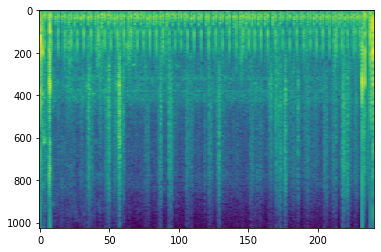

In [21]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(spectrograms))

# display a random spectrogram
plt.imshow(spectrograms[random_index], aspect='auto')
print(murmur[random_index])


In [22]:
murmur_encoded = []
print(set(murmur))

# loop through the set of murmurs and encode them as floats, Absent = 0, Unknown = 0.5, Present = 1
for murm in murmur:
    if murm == 'Absent':
        murmur_encoded.append(0)
    elif murm == 'Unknown':
        murmur_encoded.append(0.5)
    elif murm == 'Present':
        murmur_encoded.append(1)
    else:
        print("Error: Unknown murmur type")

print(len(murmur_encoded))

{'Present', 'Unknown', 'Absent'}
942


In [23]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input

# create the model
model = Sequential()

# add the input that can take in any image size

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


Audio Files Processed: 100%|██████████| 3163/3163 [04:27<00:00, 11.81it/s]


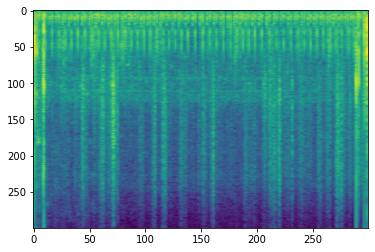

In [24]:
import tensorflow as tf
import skimage.transform as st
import numpy as np

progress_bar = tqdm.tqdm(total=len(spectrograms))
progress_bar.set_description('Spectrograms Processed')
progress_bar.n = 0
progress_bar.refresh()

# loop through the specrograms and resize them to 300x300
for i in range(len(spectrograms)):
    spectrograms[i] = st.resize(spectrograms[i], (300, 300))
    progress_bar.update(1)


plt.imshow(spectrograms[random_index], aspect='auto')


Absent
(300, 300)


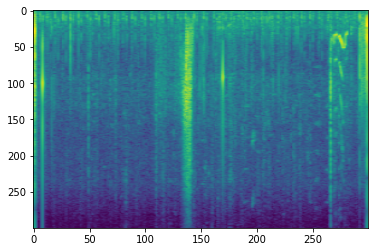

In [25]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(spectrograms))

# display a random spectrogram
plt.imshow(spectrograms[random_index], aspect='auto')
print(murmur[random_index])
print(spectrograms[random_index].shape)

In [26]:
spectrograms = np.array(spectrograms, dtype=np.float32)
murmur_encoded = np.array(murmur_encoded, dtype=np.float32)

print(spectrograms.shape)

(942, 300, 300)


In [27]:
spectrograms = spectrograms.reshape([-1, 300, 300, 1])

In [28]:
print(spectrograms.shape)

(942, 300, 300, 1)


In [29]:

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(spectrograms, murmur_encoded, epochs=10, batch_size=1)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/dense/MatMul/MatMul_1' defined at (most recent call last):
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\arcxo\AppData\Local\Temp\ipykernel_33964\4265560895.py", line 2, in <module>
      model.fit(spectrograms, murmur_encoded, epochs=10, batch_size=1)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/dense/MatMul/MatMul_1'
OOM when allocating tensor with shape[2803712,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/dense/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_905]

In [51]:
# choose a random spectrogram and predict the murmur
random_index = random.randint(0, len(spectrograms))
print(model.predict(spectrograms[random_index].reshape([1, 300, 300, 1])))

print(murmur[random_index])

1/1 [==============================] - 0s 167ms/step
[[0.]]
Absent
